# CoronaPlots report

This code focus on readability instead speed. 

> Note, you can remove all filters and others steps by replacing it by a simple loop.

In [1]:
# -*- coding: utf-8 -*-

---
# Getting current date

In [2]:
# pytz.all_timezones to see all timezones
from pytz import timezone # Defaul timezone it's ahead of Brasil(+)
from datetime import datetime, date

def isMonday():
    return date.today().isoweekday() == 1

# Note that changing linux localtime, doesn't affect Python
BRASIL_TZ = timezone('America/Campo_Grande')
DAY, MONTH, YEAR = datetime.now(BRASIL_TZ).strftime("%d %m %Y").split()

def getMonthName(month, startUpper=False):
    '''
    Need it when execute in different system's locale.

    Parameter
    ---------
    startUpper: (boolean)
    Force to fst letter be upper.

    Return
    ------
    (string) Month's names.
    '''
    month = int(month)
    monthName = ['janeiro',
               'fevereiro',
               'março',
               'abril',
               'maio',
               'junho',
               'julho',
               'agosto',
               'setembro',
               'outubro',
               'novembro',
               'dezembro'
    ]
    month = monthName[month-1] if month > 0 else monthName[-1]
    m_up = month[0].upper() + month[1:]

    return month if not startUpper else m_up 

# Get month's name
MONTH_NAME = getMonthName(MONTH, True)

# Starting logging
[See this tip 'bout logging](https://docs.python.org/3/library/logging.html#logrecord-attributes)

In [3]:
import logging as log
log.basicConfig(
    format='[%(asctime)s] : %(levelname)s: %(funcName)s : %(message)s', 
    datefmt='%H:%M:%S',
    filename='logs/LOG_{}-{}-{}.log'.format(YEAR,MONTH,DAY),
    level=log.DEBUG)
log.info('Logging created w/ success!')
log.debug('Default timezone: {}'.format(BRASIL_TZ))

# Login and Sheet load

[O2auth (in use)](https://gspread.readthedocs.io/en/latest/oauth2.html) client.
To use Google's API, you'll need to allow Google API in **[Google console](https://console.developers.google.com/iam-admin/projects)**. Also, you'll must create an business account too. 

## Login

In [4]:
from oauth2client.service_account import ServiceAccountCredentials as Credentials
import gspread # Sheets

# Login Constants
SCOPE = ['https://www.googleapis.com/auth/spreadsheets.readonly']
URL = 'https://docs.google.com/spreadsheets/d/1pkzSpLBtlzv4J_H8W9o20dWHB7MnkoStXL5h73NHkAs/edit?usp=sharing'

# Create an Client
GAUTH = Credentials.from_json_keyfile_name('credentials/nisis_credentials.json',SCOPE)
# Auth the client
GCLIENT = gspread.authorize(GAUTH)

In [5]:
log.info('Client acquired with success!')

## Sheet Load

In [6]:
import pandas as pd
from numpy import nan as NaN
import numpy as np

def getSheetsNames(URL, gc):
    '''
    Get all tab's names from url (sheet)

    Parameters
    ----------
    URL: (str)
    Url's sheet
    gc: (GoogleClient)
    Google client from gspread autenticated.

    Return
    ------
    (list) Sheet's tab names.
    '''
    workSheets = GCLIENT.open_by_url(URL)
    sheetsNames = [i.title for i in workSheets.worksheets()] # sheets names
    return sheetsNames


def getSheetValue(sheet_name, URL, gc, debug=False):
    '''
    Get pandas DF from sheet_name in WorkSheets. 

    Parameters
    ----------
    sheet_name: (string)
    Name of sheet

    Return
    ------
    (DataFrame) 2Dimensional sheet got it from one tab.

    Examples
    --------
    >> all_dfs = list(map(getSheetValue,sheets))
    >> list(map(lambda x: x.columns, all_dfs) )
    >> df = pd.concat(all_dfs)
    '''
    wb    = GCLIENT.open_by_url(URL) # client open this url
    sheet = wb.worksheet(sheet_name) # get value(tab) settled from cell above
    data  = sheet.get_all_values() # get csv content from spreadsheet
    df    = pd.DataFrame(data) # convert csv into DataFrame 

    df.columns = df.iloc[0] # Remove Id's columns (They're in fst row)
    df = df.iloc[1:] # Ignore fst row

    # If we have an empty column
    df.dropna(axis='columns')
    # If we have an empty row
    df.dropna(axis='rows')
    # Drop fst column (Index)
    df.drop(df.columns[0], axis=1, inplace=True)

    if debug:
        log.debug('Sem situação: ', len(list(
            filter(lambda x: type(x) is not str, df['Selecione a situação:']))))


    ############################  Treating data ##################################
    # Renaming columns
    #   We rename column by column, 'cause if we do in this way, we won't have
    #   problems with insertion of new columns. If we made this by replacing columns
    #   list to a new one.
    df.rename(columns={'Selecione a situação:': "Situation"}, inplace=True)
    df.rename(columns={'Escolha a situação do caso confirmado:':"SituationOfConfirmed"}, inplace=True)
    df.rename(columns={'Sintomas:': "Symptoms"}, inplace=True)
    df.rename(columns={'Está monitorado pela central de vigilância da saúde? ': 'Monitoring'}, inplace=True)
    df.rename(columns={'Houve internação?':'IsInterned'}, inplace=True)
    df.rename(columns={'Sexo:':'Gender'}, inplace=True)
    df.rename(columns={'Idade:':'Age'}, inplace=True)
    df.rename(columns={'Bairro:':'Neighboorhood'}, inplace=True)
    df.rename(columns={'Leito:':'HospitalClassifier'}, inplace=True)
    df.rename(columns={'Escolha a situação do caso descartado:':'Discarted'}, inplace=True)
    df.rename(columns={'Fatores de risco:':'RiskFactors'}, inplace=True)
    df.rename(columns={'Semana epidemiológica':'EpidemicWeek'}, inplace=True)
    df.rename(columns={'Data da internação:':'HospitalDate'}, inplace=True)

    # Remove columns that will not be used
    _mantain = ['Situation', 'Symptoms', 'SituationOfConfirmed', 'Monitoring', 'IsInterned', 'Gender',
        'Age', 'Neighboorhood', 'HospitalClassifier', 'Discarted', 'RiskFactors',
            'EpidemicWeek', 'HospitalDate', 'Hospital']
    _deleteCols = [ i for i in df.columns.to_list() if i not in _mantain ]
    df.drop(columns=_deleteCols, inplace=True)
    
    # Remove where Situation is empty -- In this dataframe, empty means that are duplicate
    _filter = df['Situation'] != ''
    df = df[_filter]

    # Convert all dates in HospitalDate to format dd/mm/yyyy
    # Note that we can't use Series.dt.date because we have
    # empty fields as also 'PROFISSIONAL DE SAUDE', and furthermore
    # 'FINALIZADO'.
    def toFullYear(year):
        if len(year)==8: # Means that are in format dd/mm/yy
            year = year[:6] + '20' + year[6:]
        return year
    df['HospitalDate'] = df['HospitalDate'].apply(toFullYear)

    # Convert to lower. We do this to minimize possible errors when making a string compare.
    df['Situation'] = df['Situation'].str.lower()
    df['Monitoring'] = df['Monitoring'].str.lower()
    df['SituationOfConfirmed'] = df['SituationOfConfirmed'].str.lower()
    df['HospitalClassifier'] = df['HospitalClassifier'].str.lower()
    df['Gender'] = df['Gender'].str.lower()
    df['RiskFactors'] = df['RiskFactors'].str.lower()
    df['IsInterned'] = df['IsInterned'].str.lower()
    df['Symptoms'] = df['Symptoms'].str.lower()
    
    # Fix: _nbh (empty and Spaced)
    df['Neighboorhood'] = df['Neighboorhood'].str.strip() # Spaced
    _filter = df['Neighboorhood'] == ''
    df.loc[_filter, 'Neighboorhood'] = 'Sem Bairro' # Empty

    # Fix: Convert str ages to int
    _filter = df['Age'] == ''
    df.loc[_filter, 'Age'] = 0 # put 0 in empty ages
    df['Age'] = df['Age'].apply(lambda x: int(x)) # convert to int

    # Fix: RiskFactors (empty and Spaced)
    _virtualRisk = df['RiskFactors'].tolist()
    for i in range(len(_virtualRisk)):
        _virtualRisk[i] = _virtualRisk[i].strip() # Spaced
        # Fix digitation errros
        w = _virtualRisk[i]
        if (w=='') or (w=='Não tem') or ('nao tem'==w) or ('não tem'==w) or (w=='não tem, outros'):
            _virtualRisk[i] = 'na'
    df['RiskFactors'] = _virtualRisk

    # Fix: Put N/A identifier in EpidemicWeek
    _filter = np.array( df['EpidemicWeek'].str.isdigit(), dtype=np.bool)
    df.loc[~_filter, 'EpidemicWeek'] = '#N/A' # Empty or #N/A
    df.loc[_filter, 'EpidemicWeek'] = df.loc[_filter, 'EpidemicWeek'].apply(lambda x: int(x)) # Convert to int where is a number

    df = df.reset_index(drop=True) # Drop removes old indexation 

    return df

In [7]:
DAY = 25

In [8]:
# Getting results
sheetName = "{}-{}-{}".format(DAY,MONTH,YEAR)
df = getSheetValue(sheetName, URL, GCLIENT)

log.info('Tab "{}" oppened with success!'.format(sheetName))

# Image and Copy Imports

In [9]:
# To import image in reportlab. Images are Pillow formats or BytesIO
from reportlab.lib.utils import ImageReader

from PIL import Image # Open png images
from copy import deepcopy as dp # dataframe creation and manipulation permanent

# Load Images

In [10]:
def alpha2white(img):
    # Create a white rgb background
    _img = Image.new("RGBA", img.size, "WHITE") 
    _img.paste(img, (0, 0), img)
    _img.convert('RGB')
    return _img.transpose(Image.FLIP_LEFT_RIGHT)

# Draw method aim's to use ImageReader or path to object
# we don't use here, 'cause of black background if alpha is 1
boy  = ImageReader( alpha2white(Image.open('img/boy.png').rotate(180)) )
girl = ImageReader( alpha2white(Image.open('img/girl.png').rotate(180)) )
logo = ImageReader( Image.open('img/logo.png').rotate(180).transpose(Image.FLIP_LEFT_RIGHT) )
maps = ImageReader( Image.open('img/map.png').rotate(180).transpose(Image.FLIP_LEFT_RIGHT) )
# It's necessary rotate because PIL inverted.

In [11]:
log.info('Images loaded successfully')

# Data analysis

> In _Google sheets_ you can use COUNTIF functions to count ocurrences in a column:
>```xls
=COUNTIF(T1:T2000;"SUSPEITO")
=SUBTOTAL(103;A2:A2000) # Count visible rows
```

## Functions

In [12]:
def similar(word1, word2, accept=False, caseSensitive=False, method='BuiltIn'):
    '''
    This method check similarity between strings. It can be used with
    two ways. Using built-in method or leveinshtein implementation by
    Antti Haapala. If use leveinshtein, need to
        >>> pip install python-Levenshtein  
    See
    ---
    https://rawgit.com/ztane/python-Levenshtein/master/docs/Levenshtein.html

    Parameters
    ----------
    word1: (string) To compare
    word2: (string) To compare
    accept: (int) If False will return percentual, otherwise, if number, 
        return true if greater or equal than the number given.
    caseSensitive: (bool) Set false to disable
    method: (string) 'BuiltIn' or 'Levenshtein'

    Return
    ------
    Similarity in percentual if accept is False, otherwise,
    True for percentual > accept
    '''

    if not caseSensitive:
        word1 = word1.lower()
        word2 = word2.lower()

    if method == 'BuiltIn':
        from difflib import SequenceMatcher
        percent = SequenceMatcher(None, word1, word2).ratio()
        return percent if not accept else percent>=accept

    elif method == 'Levenshtein':
        from Levenshtein import ratio
        percent = ratio(word1, word2)
        return percent if not accept else percent>=accept

    else:
        raise(Exception('Method not implemented.'))

def applyFilter(df, l, word, col):
    '''
    Check in "col" of "l" situation, the amount of word who matches with "word" 
      with 0.7 similarity.

    Parameters
    ----------
    df: (DataFrame) Data to analysis
    l: (list) Bitset with lines to analysis.
    word: (string) Word to analysis
    col: (string) Column to search for.
    
    Return
    ------
    (int) Amount of ocurrences.

    Example
    -------
    >> df = pd.DataFrame(['teste']*8, columns={'c1'})
            col1
      * 0	1.0
      * 1	1.0
      * 2	1.0
        3	1.0
        4	1.0
        5	1.0
        6	1.0
      * 7	1.0
    >> applyFilter(df, 3*[1]+4*[0]+[1], 'teste', 'c1')
        4
    >> 3*[1]+4*[0]+[1] == [1 1 1 0 0 0 0 1]
    '''

    def getValue(x):
        if type(x) is not str:
            return 0
        else:
            return similar(x,word,0.7)
    return int(len(list( filter(getValue, df.loc[l, col]) )))


AGES = [
    'Não informado', 
    '1 a 9', 
    '10 a 19', 
    '20 a 29', 
    '30 a 39', 
    '40 a 49', 
    '50 a 59',
    '>= 60'
]

SYMPTOMS = [
    'Tosse',
    'Febre',
    'Coriza',
    'Dor de garganta',
    'Dispneia',
    'Cefaleia'
]

# Give a vector position according to AGES list
def ageRange(age):
    if age<1: return 0
    if age>=1 and age<10: return 1
    if age>=10 and age<20: return 2
    if age>=20 and age<30: return 3
    if age>=30 and age<40: return 4
    if age>=40 and age<50: return 5
    if age>=50 and age<60: return 6
    return 7

# Convert to percent
def percentage(number, total):
    return round(number*100/total, 1)

## Data

> To be clear in variable manipulation, every var in this section will have an d2a_ prefix (data to analysis). If it's a const will be UPPER_CASE

### Vectors

In [198]:
# Vector of positions in dataframe corresponding to situations
d2a_vConfirmed = np.array( df['Situation']=='confirmado', dtype=np.bool )
d2a_vDunderI = np.array( df['Monitoring']=='obito em investigacao', dtype=np.bool ) # deaths under investigation
d2a_vSuspect = np.array( df['Situation']=='suspeito', dtype=np.bool ) | d2a_vDunderI
d2a_vDiscarted = np.array( df['Situation']=='descartado', dtype=np.bool )
d2a_vCinterned = np.array( df['SituationOfConfirmed']=='internado', dtype=np.bool ) # Only for those confirmed interned
d2a_vInterned = np.array( df['IsInterned']=='sim', dtype=np.bool ) # suspects, confirmed, discarted etc 

# Only for those suspects interned
d2a_vSinterned = np.array( df['Monitoring']=='internado', dtype=np.bool ) & d2a_vSuspect # We can't use loc, cause it will raise only true ones
d2a_vHospitals = np.array( df['Hospital'].str.len() > 4, dtype=np.bool) # Find hospitals with str lenght > 4 (Belo Horizonte)
d2a_vMonitoring = np.array(df['Monitoring']=='sim', dtype=np.bool ) # Those that are not in hospital

### Total of

In [199]:
# Total of ..
# d2a_TofDiscarted = np.count_nonzero(d2a_vDiscarted) # Discarted cases
# d2a_TofDunderI = np.count_nonzero(d2a_vDunderI)     # Total of deaths under inestigation

# Total of Confirmed
d2a_TofConfirmed = np.count_nonzero(d2a_vConfirmed)
d2a_TofCrecover = applyFilter(df, d2a_vConfirmed,'recuperado','SituationOfConfirmed')
d2a_TofCmonitoring = np.count_nonzero(d2a_vMonitoring & d2a_vConfirmed)
d2a_TofCinterned = np.count_nonzero(d2a_vCinterned)
d2a_TofCdead = applyFilter(df, d2a_vConfirmed,'óbito','SituationOfConfirmed')
d2a_TofCfemale = applyFilter(df, d2a_vConfirmed,'f','Gender')
d2a_TofCmale = applyFilter(df, d2a_vConfirmed,'m','Gender')
d2a_TofCcormobity = np.count_nonzero(df.loc[d2a_vConfirmed, 'RiskFactors']=='na')
d2a_TofCassymptomatic = np.count_nonzero(df.loc[d2a_vConfirmed, 'Symptoms']=='')
# Create vectors of symptoms
d2a_vCsymptoms    = [0]*len(SYMPTOMS) # Confirmed
for i in df.loc[d2a_vConfirmed, 'Symptoms']:
    line = i.split(',')
    line = [i.strip() for i in line]
    for s in range(len(SYMPTOMS)):
        for l in line:
            if similar(SYMPTOMS[s], l, 0.75):
                d2a_vCsymptoms[s] += 1

# UTI
d2a_TofCuti

# Total of Suspects in ...
d2a_TofSuspect = np.count_nonzero(d2a_vSuspect)
d2a_TofSmonitor = np.count_nonzero(d2a_vMonitoring & d2a_vSuspect)
d2a_TofSrecover = applyFilter(df, d2a_vSuspect,'recuperado','SituationOfConfirmed')
d2a_TofSinterned = np.count_nonzero(d2a_vInterned & d2a_vConfirmed)
d2a_TofSdead = applyFilter(df, d2a_vSuspect,'óbito','SituationOfConfirmed')


### Week and ages

In [200]:
# Week
d2a_vCSweekName = list(set(df['EpidemicWeek']))
d2a_vCSweekName.remove('#N/A') # With this we force '#N/A' to be the first in list
d2a_vCSweekName = ['#N/A'] + d2a_vCSweekName # we use this trick to force positions below
d2a_vCSweekValue = [0]*len(d2a_vCSweekName) # same idea as ages

# Create Vectors of Ages corresponding of situations
d2a_vCage         = [0]*len(AGES) # Confirmed

# Populate vectors of week and ages
for it in df.index:
    if d2a_vConfirmed[it]:
        d2a_vCage[ ageRange(df.loc[it,'Age']) ] += 1
        _week = df.loc[it, 'EpidemicWeek']
        if _week =='#N/A':
            _week = 0
        # Note that week value to"1'\n".strip()ok both situations.
        d2a_vCSweekValue[_week-9 if _week>0 else 0] += 1

### Neighboorhood

In [201]:
# Where don't have an NHD the type is NaN, due that, we can't access it
_nbh = []
for i in set(df['Neighboorhood']): 
    conf  = len(list(filter(lambda x: x, df.loc[d2a_vConfirmed, 'Neighboorhood']==i)))
    # susp  = len(list(filter(lambda x: x, df.loc[d2a_vSuspect, 'Neighboorhood']==i)))
    # anali = len(list(filter(lambda x: x, df.loc[d2a_vAnalysis, 'Neighboorhood']==i)))
    _nbh.append({ 'Neighboorhood': i, 'qtdConf': conf})#, 'qtdAnalis': anali})
# Sort by ascending order
d2a_vNeighboorhood = sorted(_nbh, key=lambda k: k['qtdConf'], reverse=True)

### Covid growth infos

In [202]:
# Now we must access a stored data which refers to oldiest reports
# This is needed, because the sheetsheet change the current situation
# over time, losing the oldiest suspects, e.g.
_cdate = '{}-{}-{}'.format(YEAR, MONTH, DAY)

# Import database's library
import sqlite3

# Connect to sqlite database used to store the data of the past mondays
database = sqlite3.connect("others/database.sqlite")

# Load the data into a DataFrame
d2a_dfCStimeline = pd.read_sql_query(
    "SELECT * from Covid_and_Suspects_timeline", 
    database,
    index_col="Id"
)

# Update the database if it's monday
if isMonday():
    # If the date already exist in df, update it
    if _cdate in d2a_dfCStimeline['Data'].tolist():
        _pos = d2a_dfCStimeline['Data']==_cdate
        d2a_dfCStimeline.loc[_pos, 'Sindrome'] = np.int64(d2a_TofSuspect)
        d2a_dfCStimeline.loc[_pos, 'Covid'] = np.int64(d2a_TofConfirmed)
    # If don't (runned at first time in the monday), create a new row
    else:
        d2a_dfCStimeline = d2a_dfCStimeline.append({
            'Data': _cdate,
            'Sindrome': np.int64(d2a_TofSuspect),
            'Covid': np.int64(d2a_TofConfirmed)
            },
            ignore_index=True)


# Write the dataframe d2a_dfCStimeline to the database
d2a_dfCStimeline.to_sql(
    "Covid_and_Suspects_timeline", # Table name
    database,                      # Database name
    if_exists="replace",           # Replace table if exist
    index_label="Id",              # Index name
    index=True                     # Enable index name
)

# Close DB connection
database.close()

In [15]:
# Logs
log.debug('Data: df.shape[0] → {}'.format(df.shape[0]))
log.info('Data analysis')
log.info('IsMonday → {}'.format(isMonday()))

# Plots

## Functions

In [196]:
import matplotlib.pyplot as plt
import seaborn as sns # Change color plot
from io import BytesIO # Image buff
from matplotlib.colors import to_rgba # Create palette 

def horizontalBarPlot(x,y, siz, palette="Oranges"):
    '''
    Generate plot in horizontal, equaly spaced

    Parameters
    ----------
    x: (list of int) Values
    y: (list of int) Labels
    siz: (tuple of int) Figure size
    palletes: (str) Colors tone in seaborn

    Return
    ------
    Buffer with image ready to plot in reportlab
    '''

    sns.set_style('darkgrid')

    fig = plt.figure( figsize=siz )

    plt.tick_params(
      axis='x',          # changes apply to the x-axis
      which='both',      # both major and minor ticks are affected
      bottom=False,      # ticks along the bottom edge are off
      labelbottom=False) # labels along the bottom edge are off
    ax = sns.barplot(x=x, y=y, palette=palette)

    _currSpace = ax.get_xticks()
    _currSpace = _currSpace[1] - _currSpace[0]
    plt.xticks(np.arange(0, max(x)+_currSpace, _currSpace))

    # Create annotions marks using total amount of infected
    maxX = max(x)
    _y = 0
    for i in x:
        ax.text(i + maxX/100, _y, str(i))
        _y+=1

    fig.tight_layout() # Remove extra paddings
    # Convert fig img to buffer img
    buff =  BytesIO()
    fig.savefig(buff, format='PNG')
    buff.seek(0)
    buff = Image.open(buff).rotate(180).transpose(Image.FLIP_LEFT_RIGHT)
    return ImageReader( buff )

# --------------------
def verticalBarPlot(x,y, siz, palette="Oranges"):
    '''
    Generate plot in vertical, equaly spaced. (Based on horizontalBarPlot function)

    Parameters
    ----------
    x: (list of int) Labels
    y: (list of int) Values
    siz: (tuple of int) Figure size
    palletes: (str) Colors tone in seaborn

    Return
    ------
    Buffer with image ready to plot in reportlab
    '''
    sns.set_style('darkgrid')
    fig = plt.figure( figsize=siz )

    plt.tick_params(
      axis='y',          # changes apply to the x-axis
      which='both',      # both major and minor ticks are affected
      bottom=False,      # ticks along the bottom edge are off
      labelbottom=False) # labels along the bottom edge are off
    ax = sns.barplot(x=x, y=y, palette=palette)
    
    _currSpace = 10
    plt.yticks(np.arange(0, max(y)+2*_currSpace, _currSpace))

    # Create annotions marks using total amount of infected
    maxY = max(y)
    _x = 0
    for i in y:
        ax.text(_x - 0.05, i + maxY/100, str(i))
        _x+=1

    fig.tight_layout() # Remove extra paddings
    # Convert fig img to buffer img
    buff =  BytesIO()
    fig.savefig(buff, format='PNG')
    buff.seek(0)
    buff = Image.open(buff).rotate(180).transpose(Image.FLIP_LEFT_RIGHT)
    return ImageReader( buff )

# ------------
def scatterPlotWithData(df, y, siz, ftsize='small'):
    '''
    Generate plot in horizontal, equaly spaced

    Parameters
    ----------
    x: (list of int) Values
    y: (list of int) Labels
    siz: (tuple of int) Figure size
    palletes: (str) Colors tone in seaborn

    Return
    ------
    Buffer with image ready to plot in reportlab
    '''
    sns.set_style('darkgrid')
    from math import floor

    fig = plt.figure( figsize=siz )

    plt.plot(
        range(0, df.shape[0]),
        df[y].tolist(), 
        marker='o', 
        color='darkred', 
        linewidth=2, 
        markersize=5
    )
    
    spacingY = max(df[y])/10
    xStart = 0
    xSpace = floor( (df.shape[0] - xStart)/10 ) # It'll give me the spacing
    vxSpace = [i for i in range(xStart, df.shape[0], xSpace) ]
    vxNames = []
    
    # Convert into word like
    for i in df.loc[ vxSpace, 'Data' ].tolist():
        _c = i.split('-')
        vxNames.append("{}/{}".format(_c[-1], getMonthName(_c[1])) )
    
    plt.xticks(vxSpace, vxNames, rotation=90)
    
    # Put number y values as annotations
    for i in range(df.shape[0]):
        _v = df.loc[i,y]
        plt.text(
          i, 
          _v+spacingY, 
          str(_v),
          fontsize=ftsize,
          rotation=90,
          verticalalignment='baseline', 
          horizontalalignment='center'
        )
    
    # Grid Y positions numbers
    maxY = max(df[y])
    plt.yticks( 
        range(0,maxY+300, 100) 
    )

    fig.tight_layout() # Remove extra paddings
    # Convert fig img to buffer img
    buff =  BytesIO()
    fig.savefig(buff, format='PNG')
    buff.seek(0)
    buff = Image.open(buff).rotate(180).transpose(Image.FLIP_LEFT_RIGHT)
    return ImageReader( buff )

# ----------
def piePlot(labels,values, siz,palette="Oranges"):
    '''
    Generate plot in horizontal, equaly spaced

    Parameters
    ----------
    x: (list of int) Values
    y: (list of int) Labels
    siz: (tuple of int) Figure size
    palletes: (str) Colors tone in seaborn

    Return
    ------
    Buffer with image ready to plot in reportlab
    '''
    sns.set_style('darkgrid')
    # Pie chart, where the slices will be ordered and plotted counter-clockwise:
    explode = (0, 24)

    fontsize=7
    loc="center left"
    bbox_to_anchor=(1, 0, 0.5, 1)
    
    fig1, ax1 = plt.subplots(figsize=siz)
    wedges, texts, autotexts = ax1.pie(values, explode=explode, autopct='%1.1f%%',
            shadow=False, startangle=90, radius=180)
    ax1.axis('equal')
    ax1.legend(labels,
        loc=loc,
        bbox_to_anchor=bbox_to_anchor,
        fontsize=9)
    plt.setp(autotexts, size=fontsize*1.5, color='white', weight="bold")
    
    # Convert fig img to buffer img
    buff =  BytesIO()
    fig1.tight_layout()
    
    fig1.savefig(buff, format='PNG')
    buff.seek(0)
    buff = Image.open(buff).rotate(180).transpose(Image.FLIP_LEFT_RIGHT)
    return ImageReader( buff )



def accelerometerPlot(value, total, siz):
    '''
    Generate plot in horizontal, equaly spaced

    Parameters
    ----------
    value: (int) equivalent to data
    siz: (tuple of int) Figure size

    Return
    ------
    Buffer with image ready to plot in reportlab
    '''
    sns.set_style('darkgrid')    
    
    fig, ax = plt.subplots( figsize=siz )

    colors = {
        'red': to_rgba('#E4271C'),
        'yellow': to_rgba('#E3B36A'),
        'green': to_rgba('#719A58'),
        'green2': to_rgba('#325326'),
        'transparent': to_rgba('#FFFFFF',0)
    }

    size = 0.3
    
    # Draw a pie plot
    ax.pie(
        [2,1,1,2,6],
        startangle=0,
        counterclock=True,
        colors=[colors['red'],colors['yellow'],colors['green'],colors['green2'],'white'],
        wedgeprops = {
            'linewidth': 0,
            'width':size, 
            'edgecolor':'w'
        }
    )
    # The width can be use to set the "fill", so you can
    # repace it by using:
    #     circle = plt.Circle( (0,0), 0.7, color='white')
    #     ax.add_artist(circle)

    # Add pointer
    ax.pie(
        [100,1],
        startangle=180 - 180*(value/total)+2,
        counterclock=True,
        colors=[colors['transparent'],'black'],
        wedgeprops = {
            'linewidth': 0,
            'edgecolor':'w',
            'width': 0.6
        }
    )

    # Convert fig img to buffer img
    buff =  BytesIO()
    fig.tight_layout()
    
    fig.savefig(buff, format='PNG')
    buff.seek(0)
    buff = Image.open(buff).rotate(180).transpose(Image.FLIP_LEFT_RIGHT)
    return ImageReader( buff )


## Plots itself

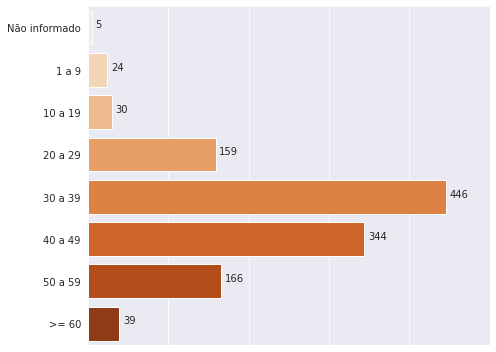

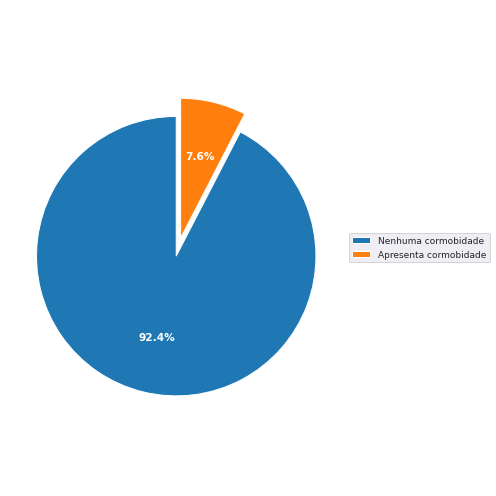

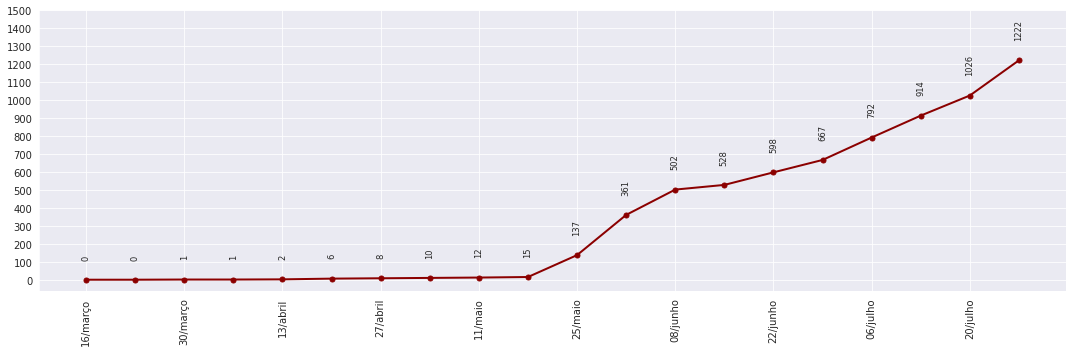

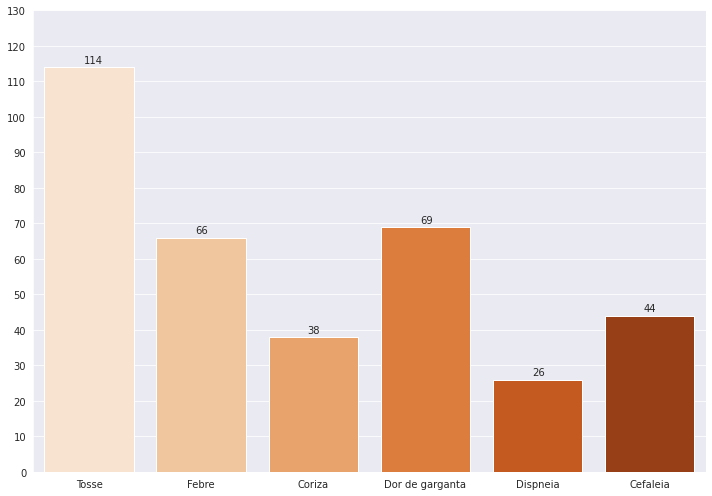

In [18]:
# Generating
# Ages Confirmed plot
graphic_C = horizontalBarPlot(d2a_vCage, AGES, (7,5))
# Cormobity confirmed plot
graphic_Ccormobity = piePlot(
    ['Nenhuma cormobidade', 'Apresenta cormobidade'], 
    [d2a_TofCcormobity,d2a_TofConfirmed-d2a_TofCcormobity], 
    (7,7))
# Confirmed growth over time
graphic_Ctimeline = scatterPlotWithData(d2a_dfCStimeline, 'Covid', (15,5) )
# Symptoms plot
graphic_Csymptons = verticalBarPlot(SYMPTOMS, d2a_vCsymptoms, (10,7))

# Hospital UTI
accelerometerPlot(90,180, (7,7))

# Hospital Enf
accelerometerPlot(90,180, (7,7))

# PDF Report

## Imports

In [19]:
from reportlab import __version__
# Canvas are used to draw in pdf (When U won't to create a document template)
from reportlab.pdfgen import canvas
# Tool to create colors models in reportlab. Colors as weel
from reportlab.lib import colors as rlabColors
# Tools to import family fonts
from reportlab.pdfbase import pdfmetrics
from reportlab.pdfbase.ttfonts import TTFont

## Font family and others settings

In [20]:
################ Font family and Colors ########################
pdfmetrics.registerFont(TTFont('FA-Solid', 'fonts/FontAwesome/fa-solid-900.ttf'))
pdfmetrics.registerFont(TTFont('FA-Regular', 'fonts/FontAwesome/fa-regular-400.ttf'))
pdfmetrics.registerFont(TTFont('FA-Brands', 'fonts/FontAwesome/fa-brands-400.ttf'))
pdfmetrics.registerFont(TTFont('Montserrat','fonts/Montserrat/Montserrat-'+'Regular.ttf'))
pdfmetrics.registerFont(TTFont('Montserratb','fonts/Montserrat/Montserrat-'+'Bold.ttf'))
pdfmetrics.registerFont(TTFont('Montserrati','fonts/Montserrat/Montserrat-'+'Italic.ttf'))
pdfmetrics.registerFont(TTFont('Montserratbi','fonts/Montserrat/Montserrat-'+'BoldItalic.ttf'))
pdfmetrics.registerFontFamily(
    'Montserrat',
    normal='Montserrat',
    bold='Montserratb',
    italic='Montserrati',
    boldItalic='Montserratbi')

# Colors not def'ed in rlabColors. CURRENT ALL COLORS USED IN PDF
colorPalette = {
    'HeadOrange': rlabColors.toColor('rgb(209,64,19)'),
    'Head2Orange': rlabColors.toColor('rgb(255,160,153)'),
    'HeadBlue': rlabColors.toColor('rgb(20,13,93)'),
    'Head2Blue': rlabColors.toColor('rgb(0,171,153)'),
    'BlueGray': rlabColors.toColor('rgb(195,210,231)'),
    'Green':  rlabColors.toColor('rgb(179,111,90)'),
    'GreenD':  rlabColors.toColor('rgb(0,255,0)'),
    'BlueFB': rlabColors.toColor('rgb(9,37,83)'),
    'IceWhite': rlabColors.toColor('rgb(233,233,233)'),
    'White': rlabColors.white,
    'Gray': rlabColors.gray,
    'Black': rlabColors.black,
    'Orange': rlabColors.toColor('rgb(237,125,49)'),
    'BrownOrange': rlabColors.toColor('rgb(200,216,51)')
} 

## Default configs

In [21]:
keywords = ['PDF report','Corona', 'Corona vírus', 'vírus', 'COVID19']
progVers = '2.0'
author   = 'Pedro Augusto C Santos'
subject  = 'NISIS - SMS de Itabira'
creator  = 'ReportLab v'+__version__
producer = 'www.reportlab.com'

# just to initialize the variable
yPos = None
page = None

# To the settings before I just need a way to propagate changes
# without rewrite everything. Furthermore, I'm using the characteristics
# of python, to search variables defined before to minimize the number of
# parameters that I would to put in Class, or either in a function.
# Besides, I just put into functions to be more modular.

## Generic methods

In [22]:
def pdfDrawLine(xStart, xEnd, yPos, thickness = 1, color='BlueGray'):
    '''
    Method responsable of create a line between two points
    
    Parameters
    ----------
    xStart: (int) Start x position
    xEnd: (int) End x position
    yPos: (int) Where to place it in Y axis.
    thickness: (int) <optional> Line thickness
    color: (str) String corresponding to a color in colorPalette dict.
    '''
    
    global page
    # Set line color
    page.setStrokeColor(colorPalette[color])
    # Set line width
    page.setLineWidth(thickness)
    # Set line's border (start/end style)
    page.setLineCap(2)
    # Draw line
    page.line(xStart, yPos, xEnd, yPos)


def pdfDrawLink(url, x, y, width, height, color=False):
    '''
    This function fix the link problem with the coordinates system.

    Globals
    -------
    page: (reportlab Canvas) Pdf itself.
    pgDim: (dict) 'w'=page_width, 'h'=page_height.

    Parameters
    ----------
    url: (str) Link to webpage. Consider to use "https://{}".format(url), 
                otherwise, will try to link with file.
    x: (int) X position.
    y: (int) Y position.
    width: (int) Size dimension.
    height: (int) Size dimension.
    color: (bool) If true, draws a rectangle equivalent to the area where the link are.
    '''
    global page, pgDim

    if color:
        page.setFillColor(colorPalette['Gray'])
        page.rect(x,y,width,height,fill=1,stroke=0)
    
    y = pgDim['h'] - y
    
    page.linkURL(
        url,
        (x, y, x+width, y-height),
        thickness=0
        # relative=1, # This doesn't nothing. 
        # In theory, this should be capable to use page properties instead default coordinate system (bottom up, left right)
    )

## Meta infos and begin pdf structure

In [23]:
def pdfStart(fileName):
    '''
    Defines meta informations about the pdf that will be generated.
    
    Parameters
    ----------
    filename: (str) Name of file that will be used
    
    Globals
    -------
    pgDim: (Dict) containing the file's dimensions.
    yPos: (int) Start variable who will save the y position for the next frame.
    page: (reportlab Canvas) The actual pdf itself.
    '''
    
    global pgDim, yPos, page

    xPos = 0
    yPos = 0

    page = canvas.Canvas(
        fileName,
        pagesize=(pgDim['w'],pgDim['h']),
        bottomup = 0,
        pageCompression=0,
        verbosity=0,
        encrypt=None
    )
    page.setProducer(producer)
    page.setKeywords(keywords)
    page.setCreator(creator)
    page.setAuthor(author)
    page.setSubject(subject)
    
def pdfSetTitle(t):
    '''
    Set pdf's title (meta information).
    
    Parameters
    ----------
    t: (Str) Title's string
    
    Globals
    -------
    page: (reportlab Canvas) Pdf itself.
    '''
    
    global page
    
    page.setTitle(t)
    page.setFillColor(colorPalette["White"])

## Header

In [24]:
def pdfPutHeader(c1='Black', c2='Black'):
    '''
    Create top frame of PDF.
    
    Parameters
    ----------
    c1: (str) String corresponding to a color in colorPalette dict.
    c2: (str) String corresponding to a color in colorPalette dict.
    
    Globals
    -------
    yPos: (int) Start variable who will save the y position for the next frame.
    page: (reportlab Canvas) Pdf itself.
    pgDim: (dict) 'w'=page_width, 'h'=page_height.
    '''
    global page, yPos, pgDim
    
    # Set default startup y position
    yPos = 40
    
    # Top line
    space = 40
    pdfDrawLine(space, pgDim['w']-space, yPos, 2, 'Orange')
    yPos += 30
    
    # Draw title
    page.setFont("Montserrat", 21)
    page.setFillColor(colorPalette['Black'])
    page.drawCentredString(
        pgDim['w']/2, 
        yPos,
        "BOLETIM COVID-19 DE MONITORAMENTO SEMANAL"
    )
    yPos += 30

    # Draw Subtitle
    space = 200
    page.setFont("Montserratb",11)
    page.drawString(
        space, 
        yPos,
        "ITABIRA / MG"
    )
    page.drawString(
        pgDim['w']/2, 
        yPos,
        "—"
    )
    page.drawString(
        pgDim['w'] - space - 90, 
        yPos,
        "{} de {} de {}".format(DAY,MONTH_NAME,YEAR)
    )
    
    yPos += 50

## CONFIRMED CASES

### Confirmed cases: emphasis

In [25]:
def pdfPutConfirmedEmph():
    global page, yPos
    
    # Draws title's rectangle
    space = 10
    height = 40
    page.setFillColor(colorPalette['Orange'])
    page.rect(space, yPos, pgDim['w']-2*space, height, stroke=0, fill=1)
    yPos += 0.6 * height
    
    # Draws text inside title's rectangle
    page.setFont("Montserrat", 14)
    page.setFillColor(colorPalette["Black"])
    page.drawCentredString(
        pgDim['w']/2, 
        yPos,
        "CASOS CONFIRMADOS DE COVID-19 EM ITABIRA/MG"
    )
    yPos += 0.4 * height + 80
    
    
    # Draw emphasis icons
    space = 100
    page.setFont("FA-Solid",40)
    page.setFillColor(colorPalette["Gray"])
    page.drawCentredString(space, yPos,'') # User check
    space += 150
    page.drawCentredString(space, yPos,'') # Home (Household not working)
    space += 150
    page.drawCentredString(space, yPos,'') # Smile
    space += 150
    page.drawCentredString(space, yPos,'') # Hospital
    space += 150
    page.drawCentredString(space, yPos,'') # Dead
    yPos += 40
    
    # Draw emph text
    page.setFont("Montserrat", 12)
    space = 100
    page.drawCentredString(space, yPos, "CONFIRMADOS")
    space += 150
    page.drawCentredString(space, yPos, "EM MONITORAMENTO")
    space += 150
    page.drawCentredString(space, yPos, "RECUPERADOS")
    space += 150
    page.drawCentredString(space, yPos, "INTERNADOS")
    space += 150
    page.drawCentredString(space, yPos, "ÓBITOS")
    yPos += 20
    
    
    # Draw rectangles
    height = 50
    page.setFillColor(colorPalette["BrownOrange"])
    space = 50
    page.rect(space, yPos, 100, height, stroke=0, fill=1)
    space += 150
    page.rect(space, yPos, 100, height, stroke=0, fill=1)
    space += 150
    page.rect(space, yPos, 100, height, stroke=0, fill=1)
    space += 150
    page.rect(space, yPos, 100, height, stroke=0, fill=1)
    space += 150
    page.rect(space, yPos, 100, height, stroke=0, fill=1)
    yPos += 0.6 * height
    
    # Draw text to put inside rectangles
    page.setFont("Montserratb", 18)
    page.setFillColor(colorPalette["Gray"])
    space = 100
    page.drawCentredString(space, yPos, str(d2a_TofConfirmed))
    space += 150
    page.drawCentredString(space, yPos, str(d2a_TofCmonitoring))
    space += 150
    page.drawCentredString(space, yPos, str(d2a_TofCrecover))
    space += 150
    page.drawCentredString(space, yPos, str(d2a_TofCinterned))
    space += 150
    page.drawCentredString(space, yPos, str(d2a_TofCdead))
    
    yPos += 100

### Confirmed cases: brief plots

In [26]:
def pdfPutConfirmedPlots():
    global page, yPos
    
    # Draw plots caption
    space = 200
    page.setFont("Montserrat", 12)
    page.setFillColor(colorPalette["Gray"])
    page.drawCentredString(pgDim['w'] - space, yPos, "Por faixa etária")
    page.drawCentredString(space, yPos + 88, "Por sexo")
    yPos += 30
    
    # Draw boy, girl and plot
    page.drawImage(boy, space - 100, yPos + 88, 35, 114)
    page.drawImage(girl, space + 50, yPos + 88, 40, 114)
    page.drawImage(graphic_C, 400, yPos, 350, 250, preserveAspectRatio=True)
    yPos += 220
    
    # Draw boy and girl numbers
    page.setFont("Montserrat",14)
    page.setFillColor(colorPalette['Gray'])
    page.drawCentredString(space - 80, yPos, str(d2a_TofCfemale))
    page.drawCentredString(space + 70, yPos, str(d2a_TofCmale))
    yPos += 20
    page.setFont("Montserratb",14)
    page.drawCentredString(space - 80, yPos, "{:.0f}%".format(100* d2a_TofCfemale/ (d2a_TofCfemale+d2a_TofCmale)) )
    page.drawCentredString(space + 70, yPos, "{:.0f}%".format(100* d2a_TofCmale/ (d2a_TofCfemale+d2a_TofCmale)) )
    
    yPos += 100

### Confirmed cases: symptoms

In [27]:
def pdfPutConfirmedSint():
    global page, yPos
    
    # Draw rectangle
    height = 30
    space = 10
    page.setFillColor(colorPalette["Orange"])
    page.rect(space, yPos, pgDim['w']-2*space, height, stroke=1, fill=0)
    yPos += 0.7 * height
    
    # Draw text inside rect
    page.setFont("Montserrat",14)
    page.setFillColor(colorPalette['Black'])
    page.drawCentredString(pgDim['w']/2, yPos, "COMORBIDADE E SINTOMAS")
    yPos += 20
    
    # Draw plots
    page.drawImage(graphic_Ccormobity, 5, yPos, 350, 350, preserveAspectRatio=True)
    page.drawImage(graphic_Csymptons, pgDim['w']/2 - 20, yPos-50, 400, 500, preserveAspectRatio=True)
    
    # Draw rectangles
    space = 220
    width = 130
    height = 50
    page.setFillColor(colorPalette['Gray'])
    page.rect(space, yPos+50, width, height, stroke=0, fill=1)
    space = 150
    page.rect(pgDim['w']-space, yPos+50, width, height, stroke=0, fill=1)
    yPos += height * 1.3
    
    # Draw text inside rect
    space = (220 + width/2)
    page.setFillColor(colorPalette['White'])
    page.setFont("Montserratb",8)
    page.drawCentredString(space, yPos, "NENHUMA COMRMOBIDADE")
    page.setFont("Montserratb",16)
    page.drawCentredString(space, yPos + 20, str(d2a_TofCcormobity))
    space = 100
    cstring = pgDim['w'] - 85
    page.setFillColor(colorPalette['White'])
    page.setFont("Montserratb",8)
    page.drawCentredString(cstring, yPos, "ASSINTOMÁTICOS")
    page.setFont("Montserratb",16)
    page.drawCentredString(cstring, yPos + 20, str(d2a_TofCassymptomatic))
    
    yPos += 350

### Confirmed cases: neighboorhoods

In [28]:
def pdfPutConfirmedNeighboors():
    global page, yPos

    # Draw rectangle
    height = 30
    space = 10
    page.setFillColor(colorPalette["Orange"])
    page.rect(space, yPos, pgDim['w']-2*space, height, stroke=1, fill=0)
    yPos += 0.7 * height
    
    # Draw text inside rect
    page.setFont("Montserrat",14)
    page.setFillColor(colorPalette['Black'])
    page.drawCentredString(pgDim['w']/2, yPos, "DISTRIBUIÇÃO DOS CASOS POR BAIRRO")
    

    
    multiplier = 200
    yPos_base = yPos
    half = int( len(d2a_vNeighboorhood)/2 ) + 1
    yPos += 50
    xPos = 10
    
    # Neighboor column names (left)
    page.setFillColor(colorPalette['Gray'])
    page.setFont("Montserratbi",10)
    page.drawString(xPos, yPos, "Bairros")
    page.drawCentredString(xPos + multiplier, yPos, "Casos confirmados")
    page.drawCentredString(xPos + 1.6*multiplier, yPos, "Total da população")

    # Drawing neighboorhood in pdf
    page.setFont("Montserratb",10)
    yPos += 5
    
    for i in d2a_vNeighboorhood[:half]:
        yPos+= 17
        # Total of confirmed cases
        page.drawCentredString(xPos + multiplier, yPos, str(i['qtdConf']))
        # Total of people in neighboorhood
        page.drawCentredString(xPos + 1.6*multiplier, yPos, '?')
        # Neighboorhood name
        nbh = i['Neighboorhood']
        if len(nbh)>30:
            s = nbh[:30].rfind(' ')
            page.drawString(xPos, yPos, nbh[:s])
            page.drawString(xPos, yPos+17, "   " + nbh[s:])
            yPos+= 17
        else:
            page.drawString(xPos, yPos, nbh)
        
    
    # Neighboor column names (right)
    yPos = yPos_base + 50
    xPos = pgDim['w']/2 + 15
    
    page.setFillColor(colorPalette['Gray'])
    page.setFont("Montserratbi",10)
    page.drawString(xPos, yPos, "Bairros")
    page.drawCentredString(xPos + multiplier, yPos, "Casos confirmados")
    page.drawCentredString(xPos + 1.6*multiplier, yPos, "Total da população")

    # Drawing neighboorhood in pdf
    page.setFont("Montserratb",10)
    yPos += 5
    
    for i in d2a_vNeighboorhood[half:]:
        yPos+= 17
        # Total of confirmed cases
        page.drawCentredString(xPos + multiplier, yPos, str(i['qtdConf']))
        # Total of people in neighboorhood
        page.drawCentredString(xPos + 1.6*multiplier, yPos, '?')
        # Neighboorhood name
        nbh = i['Neighboorhood']
        if len(nbh)>30:
            s = nbh[:30].rfind(' ')
            page.drawString(xPos, yPos, nbh[:s])
            page.drawString(xPos, yPos+17, "   " + nbh[s:])
            yPos+= 17
        else:
            page.drawString(xPos, yPos, nbh)
        

    yPos += 100

### Confirmed cases: external plots

In [29]:
def pdfPutConfirmedExternal():
    global page, yPos
    
    # Titles
    page.setFont("Montserrat",14)
    page.setFillColor(rlabColors.gray)
    page.drawCentredString(
        pgDim['w']/2,
        yPos,
        "PERFIL EPIDEMIOLÓGICO DOS ÓBITOS CONFIRMADOS DE COVID-19, MG, 2020")
    yPos += 40
    
    
    # Draw plots caption
    space = 200
    page.setFont("Montserrat", 12)
    page.setFillColor(colorPalette["Gray"])
    page.drawCentredString(pgDim['w'] - space, yPos, "Por faixa etária")
    page.drawCentredString(space, yPos + 88, "Por sexo")
    yPos += 30
    
    # Draw boy, girl and plot
    page.drawImage(boy, space - 100, yPos + 88, 35, 114)
    page.drawImage(girl, space + 50, yPos + 88, 40, 114)
    page.drawImage(graphic_C, 400, yPos, 350, 250)
    yPos += 240
    
    # Draw boy and girl numbers
    page.setFont("Montserrat",14)
    page.setFillColor(colorPalette['Gray'])
    page.drawCentredString(space - 80, yPos, str(d2a_TofCfemale))
    page.drawCentredString(space + 70, yPos, str(d2a_TofCmale))
    
    yPos += 100

### Confirmed cases: case growth plot

In [30]:
def pdfPutConfirmedGrowth():
    global page, yPos

    # Titles
    page.setFont("Montserrat",14)
    page.setFillColor(rlabColors.gray)
    page.drawCentredString(
      pgDim['w']/2,
      yPos,
      "CRESCIMENTO DE CASOS CONFIRMADOS")
    yPos += 30

    # Draw graphic disease
    _dist = 20
    page.drawImage(
      graphic_Ctimeline, 
      _dist, 
      yPos,
      pgDim['w']-2*_dist,
      (pgDim['w']-2*_dist)/3
    )
    yPos += 350

### Confirmed cases: external 2 plots

In [31]:
def pdfPutConfirmedExternal2():
    global page, yPos
    
    # Draw plots caption
    space = 200
    page.setFont("Montserrat", 12)
    page.setFillColor(colorPalette["Gray"])
    page.drawCentredString(pgDim['w'] - space, yPos, "Por faixa etária")
    page.drawCentredString(space, yPos + 88, "Por sexo")
    yPos += 30
    
    # Draw boy, girl and plot
    page.drawImage(boy, space - 100, yPos + 88, 35, 114)
    page.drawImage(girl, space + 50, yPos + 88, 40, 114)
    page.drawImage(graphic_C, 400, yPos, 350, 250)
    yPos += 240
    
    # Draw boy and girl numbers
    page.setFont("Montserrat",14)
    page.setFillColor(colorPalette['Gray'])
    page.drawCentredString(space - 80, yPos, str(d2a_TofCfemale))
    page.drawCentredString(space + 70, yPos, str(d2a_TofCmale))
    
    yPos += 100

### Confirmed cases: profile

In [32]:
def pdfPutConfirmedProfile():
    global page, yPos
    
    # Titles
    page.setFont("Montserrat",14)
    page.setFillColor(rlabColors.gray)
    page.drawCentredString(
        pgDim['w']/2,
        yPos,
        "PERFIL EPIDEMIOLÓGICO DOS ÓBITOS CONFIRMADOS DE COVID-19, MG, 2020")
    yPos += 40
    
    # Draw plots caption
    space = 200
    page.setFont("Montserrat", 12)
    page.setFillColor(colorPalette["Gray"])
    page.drawCentredString(pgDim['w'] - space, yPos, "Por faixa etária")
    page.drawCentredString(space, yPos + 88, "Por sexo")
    yPos += 30
    
    # Draw boy, girl and plot
    page.drawImage(boy, space - 100, yPos + 88, 35, 114)
    page.drawImage(girl, space + 50, yPos + 88, 40, 114)
    page.drawImage(graphic_C, 400, yPos, 350, 250)
    yPos += 240
    
    # Draw boy and girl numbers
    page.setFont("Montserrat",14)
    page.setFillColor(colorPalette['Gray'])
    page.drawCentredString(space - 80, yPos, str(d2a_TofCfemale))
    page.drawCentredString(space + 70, yPos, str(d2a_TofCmale))
    
    yPos += 100


## SUSPECT CASES

### Suspect cases: emphasis

In [33]:
def pdfPutSuspectEmph():
    global page, yPos
    
    # Draws title's rectangle
    space = 10
    height = 40
    page.setFillColor(colorPalette['Orange'])
    page.rect(space, yPos, pgDim['w']-2*space, height, stroke=0, fill=1)
    yPos += 0.6 * height
    
    # Draws text inside title's rectangle
    page.setFont("Montserrat", 14)
    page.setFillColor(colorPalette["Black"])
    page.drawCentredString(
        pgDim['w']/2, 
        yPos,
        "CASOS SUSPEITOS (EM INVESTIGAÇÃO) DE COVID-19 EM ITABIRA/MG"
    )
    yPos += 0.4 * height + 80
    
    
    # Draw emphasis icons
    space = 100
    page.setFont("FA-Solid",40)
    page.setFillColor(colorPalette["Gray"])
    page.drawCentredString(space, yPos,'') # Attention
    space += 150
    page.drawCentredString(space, yPos,'') # Home (Household not working)
    space += 150
    page.drawCentredString(space, yPos,'') # Smile
    space += 150
    page.drawCentredString(space, yPos,'') # Hospital
    space += 150
    page.drawCentredString(space, yPos,'') # Dead
    yPos += 40
    
    # Draw emph text
    page.setFont("Montserrat", 12)
    space = 100
    page.drawCentredString(space, yPos, "SUSPEITOS")
    space += 150
    page.drawCentredString(space, yPos, "EM MONITORAMENTO")
    space += 150
    page.drawCentredString(space, yPos, "RECUPERADOS")
    space += 150
    page.drawCentredString(space, yPos, "INTERNADOS")
    space += 150
    page.drawCentredString(space, yPos, "ÓBITOS")
    yPos += 20
    
    
    # Draw rectangles
    height = 50
    page.setFillColor(colorPalette["BrownOrange"])
    space = 50
    page.rect(space, yPos, 100, height, stroke=0, fill=1)
    space += 150
    page.rect(space, yPos, 100, height, stroke=0, fill=1)
    space += 150
    page.rect(space, yPos, 100, height, stroke=0, fill=1)
    space += 150
    page.rect(space, yPos, 100, height, stroke=0, fill=1)
    space += 150
    page.rect(space, yPos, 100, height, stroke=0, fill=1)
    yPos += 0.6 * height
    
    # Draw text to put inside rectangles
    page.setFont("Montserratb", 18)
    page.setFillColor(colorPalette["Black"])
    space = 100
    page.drawCentredString(space, yPos, str(d2a_TofConfirmed))
    space += 150
    page.drawCentredString(space, yPos, str(d2a_TofCmonitoring))
    space += 150
    page.drawCentredString(space, yPos, str(d2a_TofCrecover))
    space += 150
    page.drawCentredString(space, yPos, str(d2a_TofCinterned))
    space += 150
    page.drawCentredString(space, yPos, str(d2a_TofCdead))
    
    yPos += 100

## Overview micro Itabira

In [34]:
def pdfPutOverviewMap():
    global page, yPos
    
    # Draws title's rectangle
    space = 10
    height = 40
    page.setFillColor(colorPalette['Orange'])
    page.rect(space, yPos, pgDim['w']-2*space, height, stroke=0, fill=1)
    yPos += 0.6 * height
    
    # Draws text inside title's rectangle
    page.setFont("Montserrat", 14)
    page.setFillColor(colorPalette["Black"])
    page.drawCentredString(
        pgDim['w']/2, 
        yPos,
        "PANORAMA DAS CIDADES DA MICRORREGIÃO DE SAÚDE DE ITABIRA"
    )
    yPos += 0.4 * height + 40
    
    # Draw map
    w = maps.getSize()[1]*0.7
    h = maps.getSize()[1]*0.7
    page.drawImage(maps, pgDim['w']/2 - w/2, yPos, w, h, preserveAspectRatio=True)
    yPos += 80

    # Draw text over map
    page.setFont("Montserratb", 9)
    page.setFillColor(colorPalette["Black"])
    space = pgDim['w']/2
    page.drawCentredString(space + 80, yPos + 30, "FERROS")
    page.drawCentredString(space + 80, yPos + 40, "?")
    page.drawCentredString(space - 30, yPos + 20, "SANTO")
    page.drawCentredString(space - 30, yPos + 30, "ANTÔNIO DO")
    page.drawCentredString(space - 30, yPos + 40, "RIO ABAIXO")
    page.drawCentredString(space - 30, yPos + 50, "?")
    page.drawCentredString(space - 0, yPos + 75, "SÃO SEBASTIÃO DO RIO PRETO")
    page.drawCentredString(space - 0, yPos + 85, "?")
    page.drawCentredString(space - 130, yPos + 50, "MORRO DO PILAR")
    page.drawCentredString(space - 130, yPos + 60, "?")
    page.drawCentredString(space, yPos + 105, "PASSABÉM")
    page.drawCentredString(space, yPos + 115, "?")
    page.drawCentredString(space - 90, yPos + 125, "ITAMBÉ DO MATO DENTRO")
    page.drawCentredString(space - 90, yPos + 135, "?")
    page.drawCentredString(space + 20, yPos + 150, "SANTA MARIA")
    page.drawCentredString(space + 20, yPos + 160, "DE ITABIRA")
    page.drawCentredString(space + 20, yPos + 170, "?")
    page.drawCentredString(space - 50, yPos + 220, "ITABIRA")
    page.drawCentredString(space - 50, yPos + 230, "?")
    page.drawCentredString(space - 150, yPos + 290, "BOM JESUS")
    page.drawCentredString(space - 150, yPos + 300, "DO AMPARO")
    page.drawCentredString(space - 150, yPos + 310, "?")
    page.drawCentredString(space - 70, yPos + 350, "SÃO GONÇALO")
    page.drawCentredString(space - 70, yPos + 360, "DO RIO ABAIXO")
    page.drawCentredString(space - 70, yPos + 370, "?")
    page.drawCentredString(space - 150, yPos + 360, "BARÃO DE")
    page.drawCentredString(space - 150, yPos + 370, "COCAIS")
    page.drawCentredString(space - 150, yPos + 380, "?")
    page.drawCentredString(space - 220, yPos + 480, "SANTA")
    page.drawCentredString(space - 220, yPos + 490, "BÁRBARA")
    page.drawCentredString(space - 220, yPos + 500, "?")
    page.drawCentredString(space - 110, yPos + 490, "CATAS ALTAS")
    page.drawCentredString(space - 110, yPos + 500, "?")

    yPos += h + 50

## Hospital occupation

In [35]:
def pdfPutHospital():
    global page, yPos
    
    # Draw line
    space = 20
    pdfDrawLine(space, pgDim['w']-space, yPos, 2, 'Gray')
    yPos += 30
    
    # Titles
    page.setFont("Montserrat",14)
    page.setFillColor(colorPalette['Gray'])
    page.drawCentredString(
        pgDim['w']/2,
        yPos,
        "TAXA DE OCUPAÇÃO HOSPITALAR — LEITOS OPERACIONAIS")
    yPos += 40
    
    
    # Draw plots caption
    space = 200
    page.setFont("Montserrat", 12)
    page.setFillColor(colorPalette["Gray"])
    page.drawCentredString(pgDim['w'] - space, yPos, "Por faixa etária")
    page.drawCentredString(space, yPos + 88, "Por sexo")
    yPos += 30
    
    # Draw boy, girl and plot
    page.drawImage(boy, space - 100, yPos + 88, 35, 114)
    page.drawImage(girl, space + 50, yPos + 88, 40, 114)
    page.drawImage(graphic_C, 400, yPos, 350, 250)
    yPos += 240
    
    # Draw boy and girl numbers
    page.setFont("Montserrat",14)
    page.setFillColor(colorPalette['Gray'])
    page.drawCentredString(space - 80, yPos, str(d2a_TofCfemale))
    page.drawCentredString(space + 70, yPos, str(d2a_TofCmale))
    
    yPos += 100


## Others

### Footer

In [36]:
def putFooter():
    global page
    
    # page.drawImage(logo, pgDim['w']-200, pgDim['h']-70, 125, 38) # Removed -- elections
    
    # Set color
    page.setFillColor(colorPalette["Gray"])

    # Draw icons
    page.setFont("FA-Solid",12)
    page.drawCentredString(pgDim['w']/2 - 100, pgDim['h']-40,'') # Link
    page.setFont("FA-Brands",12)
    page.drawCentredString(pgDim['w']/2 - 110, pgDim['h']-25,'') # Facebook
    
    # Draw Text
    page.setFont("Montserrat",12)
    page.drawCentredString(pgDim['w']/2, pgDim['h']-60, "Mais informações:") # xpos = 150
    _site = 'novoportal.itabira.mg.gov.br/'
    _fb = 'facebook.com/prefeituraitabira'
    
    space = 100
    pdfDrawLink('http://{}'.format(_site), pgDim['w']/2-space, pgDim['h']-50, 2*space, 10)
    pdfDrawLink('https://{}'.format(_fb), pgDim['w']/2-space, pgDim['h']-35, 2*space, 10)

    page.drawCentredString(pgDim['w']/2, pgDim['h']-40,_site) #'<link href="{0}">{0}</link>'.format(_site))
    page.drawCentredString(pgDim['w']/2, pgDim['h']-25,_fb)# '<link href="{0}">{0}</link>'.format(_fb))

### Save

In [37]:
def save():
    global page

    page.save()  

### Get internal pdf

In [38]:
def getInternal(fileName):
    pdfStart(fileName)
    pdfSetTitle('Boletim Interno')
    pdfPutHeader()
    pdfPutConfirmedEmph()
    pdfPutConfirmedPlots()
    pdfPutConfirmedSint()
    pdfPutConfirmedNeighboors()
    pdfPutConfirmedExternal()
    pdfPutConfirmedGrowth()
    pdfPutConfirmedExternal2()
    pdfPutConfirmedProfile()
    pdfPutSuspectEmph()
    pdfPutOverviewMap()
    pdfPutHospital()
    
    putFooter()
    save()

### Get external pdf

In [39]:
def getExternal(fileName):
    pdfStart(fileName)
    pdfSetTitle('Boletim Externo')
    pdfPutHeader('BlueFB','Head2Blue')
    pdfPutConfirmedPlots()
    putSecTwo()
    putFooter()
    save()

# Generate pdfs

## External PDF

In [40]:
# fileName = 'pdfs/Boletim-Externo_{}-{}-{}.pdf'.format(DAY,MONTH_NAME,YEAR)
# pgDim = {'w':792,'h':1150}

# getExternal(fileName)

## Internal PDF

In [41]:
def AUX():
    fileName = 'pdfs/Boletim-Interno_{}-{}-{}.pdf'.format(DAY,MONTH_NAME,YEAR)
    pgDim = {'w':792,'h':5500}

    getInternal(fileName)

In [42]:
AUX()

NameError: name 'pgDim' is not defined